## CSE 4705 Project: Unsupervised Analysis

Tom McCarthy & Filip Graham

Imports

In [92]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


## Anomaly Detection Using Isolation Forest

We start by performing anomaly detection on our dataset to explore municipalities with "rare" characteristics. Knowing anomalies can also help provide context for regular clustering, because anomalies can reduce clustering metrics and effectivness.

We use Isolation Forest because it is a robust model for high dimensional data.

In [68]:
raw_data = pd.read_csv("new_cleaned.csv")
print(raw_data.shape)

(812, 59)


As always, we use StandardScaler to pre-process the numeric columns 

In [74]:
non_numeric_cols = ['town', 'year']

numeric_cols = raw_data.columns.drop(labels = non_numeric_cols) 

scaler = StandardScaler()
standardized_data = pd.DataFrame(scaler.fit_transform(raw_data[numeric_cols]), columns=numeric_cols)

In [75]:
iso_forest = IsolationForest(random_state=42)
labels = iso_forest.fit_predict(standardized_data)

### Visualizing the model results and Evaluating Model Performance

First we use a model function decision_function() to generate the anomaly scores for each record. The anomaly scores quantifies how "abnormal" a record is, with the more negative scores being further away from the norm.

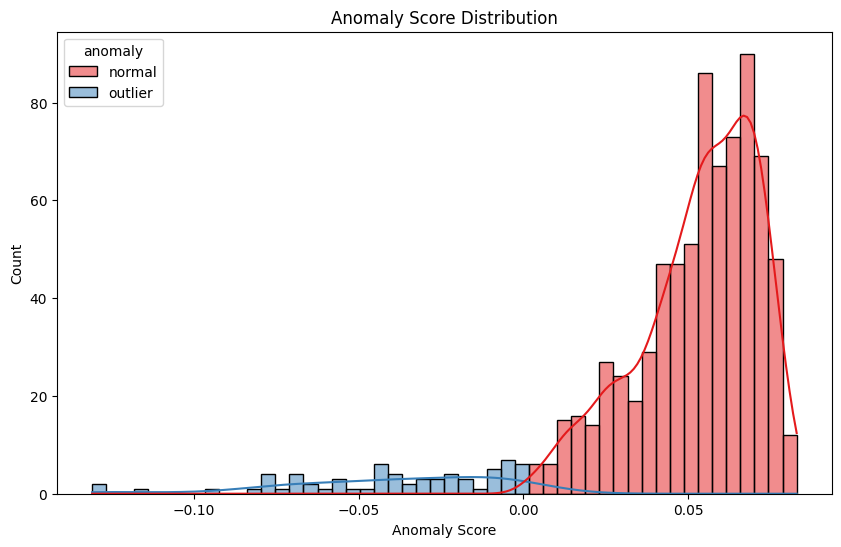

In [76]:
scores = iso_forest.decision_function(standardized_data)

# Convert to more intuitive format
df_results = pd.DataFrame({'score': scores, 'anomaly': labels})
df_results['anomaly'] = df_results['anomaly'].map({1: 'normal', -1: 'outlier'})

# Plot score distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_results, x='score', hue='anomaly', bins=50, kde=True, palette='Set1')
plt.title('Anomaly Score Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.show()

We see that the vast majority of datapoints are labeled as normal, as expected. The outlier score buckets have fewer counts than the normal ones, so it looks like the model is doing a good job of finding a fair boundary.

It is difficult to visualize the indidivual datapoints of high dimensional data, so we try using PCA to reduce the dimensionality. Since our dataset is not complete, we used SimpleImputer to impute NaN values so that we can apply dimensionality reduction.

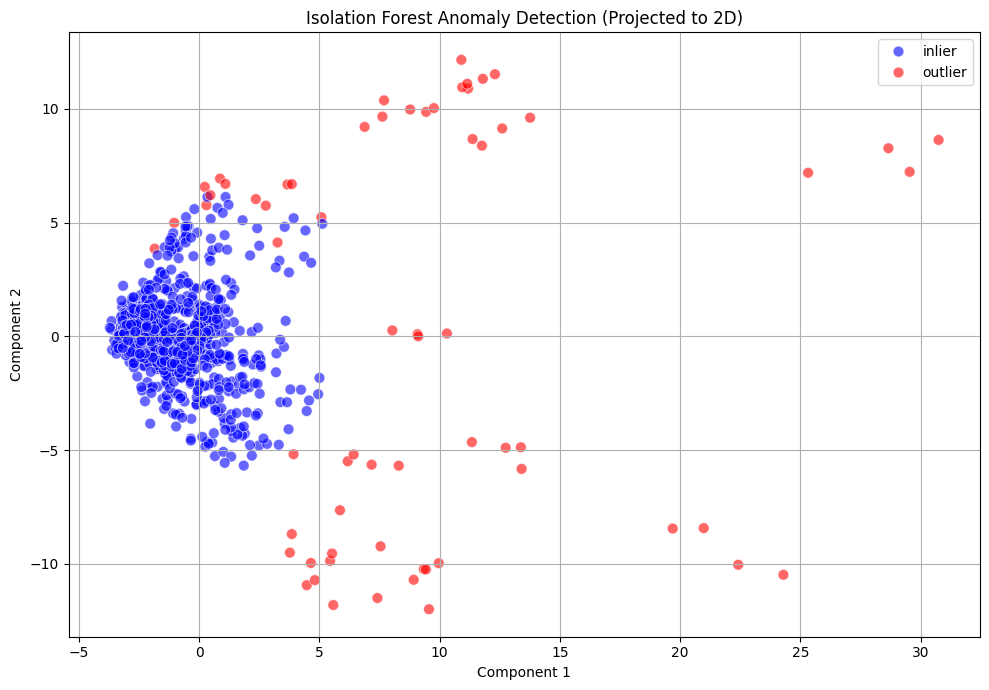

In [77]:
imputer = SimpleImputer()
std_data_imputed = imputer.fit_transform(standardized_data, None)

reducer = PCA(n_components=2)

std_data_reduced = reducer.fit_transform(std_data_imputed)

reduced_data_summary = pd.DataFrame({
    'Dimension1': std_data_reduced[:, 0],
    'Dimension2': std_data_reduced[:, 1],
    'label': labels,
    'score': scores
})
reduced_data_summary['label'] = reduced_data_summary['label'].map({1: 'inlier', -1: 'outlier'})

# Step 4: Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=reduced_data_summary, x='Dimension1', y='Dimension2', hue='label', palette={'inlier': 'blue', 'outlier': 'red'}, alpha=0.6, s=60)
plt.title('Isolation Forest Anomaly Detection (Projected to 2D)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



The separation between normal and outlier values is not perfect, but it is still quite good. We see a clear "normal" cluster and outliers which are very far away.

Since this is an anomaly detection model, a traditional clustering metric like Silhouette Score would not work well because the model isn't generating clusters. Furthermore, since we are using an unsupervised version because we don't have outlier labels, we cannot use metrics like Accuracy either. One possible way to evaluate the model would be to generate synthetic examples of outliers and compare the labels. However, since we are not domain experts, we stick with the visualizations and qualitative metrics.

### Exploring the anomalies

Next, we look into characteristics of the anomalies. First, I get the most "important" features that affected the anomaly score most.

In [87]:
raw_data['label'] = labels
raw_data['score'] = scores
anomalies = raw_data.sort_values('score')
# print(raw_data_sorted.columns)
print(anomalies.head(20)[['year', 'town', 'score']])

     year        town     score
56   2019   Greenwich -0.130867
393  2021   Greenwich -0.128254
224  2020   Greenwich -0.115276
562  2022   Greenwich -0.094376
134  2019    Stamford -0.081004
156  2019    Westport -0.078312
371  2021      Darien -0.076310
540  2022      Darien -0.076113
494  2021    Westport -0.075867
471  2021    Stamford -0.071752
34   2019      Darien -0.069252
302  2020    Stamford -0.068909
663  2022    Westport -0.068107
595  2022  New Canaan -0.067188
640  2022    Stamford -0.063383
63   2019    Hartford -0.062799
202  2020      Darien -0.060737
89   2019  New Canaan -0.056622
400  2021    Hartford -0.054704
325  2020    Westport -0.054226


In our previous Supervised Learning Analysis, we saw that the most expensive municipalities were "anomalous" in the sense that they did not fit our regression model for income vs. sale price. It makes sense for Greenwich, Westport, Darien, New Canaan to be anomalous since they are significantly wealthier than other towns. However, towns like Stamford would not be anomalous in that way, indicating other rarities. Let's look at Stamford.

In [85]:
standardized_data['town'] = raw_data['town']
standardized_data['year'] = raw_data['year']
standardized_data.loc[standardized_data['town'] == 'Stamford']

,count,avg_sale_price,sale_price_q1,median_sale_price,sale_price_q3,avg_sales_ratio,sales_ratio_q1,median_sales_ratio,sales_ratio_q3,avg_assessed_value,assessed_value_q1,median_assessed_value,assessed_value_q3,Equalized_net_grand_list,Estimated_population_DPH,FYE_total_net_grand_list,Grand_list_apartment,Grand_list_commercial,Grand_list_income_and_expense,Grand_list_industrial,Grand_list_land_use,Grand_list_motor_vehicle,Grand_list_net_personal_property,Grand_list_net_real_property,Grand_list_personal_property,Grand_list_public_utility,Grand_list_residential,Grand_list_ten_mill_land,Grand_list_total_net_motor_vehicle,Grand_list_total_real_property,Grand_list_vacant_land,Median_value_of_owner_occupied_homes_ACS,Mill_rate_motor_vehicle,Mill_rate_real_and_personal_property,Net_current_education_expenditures_CSDE,Net_current_education_expenditures_per_pupil_CSDE,Per_capita_income_ACS,School_enrollment_average_daily_membershipCSDE,Total_net_grand_list,Area_in_sq_miles_2020_census,Tax_exempt_property_as_a_percent_of_total,Tax_exempt_property_assessment,Total_exempt_and_taxable_property_assessment,Educational Attainment: High School Graduate: Town %,Educational Attainment: Associates Degree: Town %,Educational Attainment: Bachelors Degree: Town %,Educational Attainment: Bachelors or Higher: Town %,Educational Attainment: Master's Degree or Higher: Town %,Race/Ethnicity: White: Town %,Race/Ethnicity: Black: Town %,Race/Ethnicity: Asian: Town %,Race/Ethnicity: Hispanic: Town %,Race/Ethnicity: Other: Town %,Crime Rate: Per 100000 residents: Violent: Town %,Crime Rate: Per 100000 residents: Property: Town %,Labor Force: Unemployment Rate: Town %,Poverty Rate: Town %,score,label,town,year
134,4.290628,0.462230,0.357618,0.515413,0.419006,2.019794,1.244714,1.050643,0.635672,1.629215,0.676064,0.869707,0.785132,4.772163,4.180783,5.372557,8.828188,7.071660,-0.161349,4.398372,-0.023003,4.371716,5.817262,5.095154,4.925252,2.521570,3.722925,-0.142359,4.404138,5.059551,9.447699,0.973629,-0.459219,-0.665038,3.717518,-0.192844,0.173332,3.490799,5.224920,NaN,NaN,NaN,NaN,-1.440815,-1.550135,NaN,-2.534419,NaN,-2.452650,1.292820,2.081887,2.351575,-0.386489,1.385412,0.82043,-0.633646,0.592150,-0.081004,-1,Stamford,2019
302,4.954322,0.537080,0.642056,0.691230,0.586338,0.567583,1.084241,0.889909,0.400435,1.122039,0.985872,1.006197,0.919150,5.247497,4.407492,5.437879,9.710597,7.101550,-0.161349,4.380390,-0.023003,4.505971,5.486916,5.174602,4.650651,2.521570,3.731643,-0.142359,4.540466,5.129808,9.226164,1.019018,-0.459219,-0.496066,3.778015,-0.279223,0.241032,3.635809,5.286785,0.713012,0.095773,2.722977,5.094340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.068909,-1,Stamford,2020
471,6.117942,0.563653,0.636947,0.802507,0.666713,-0.101823,0.356720,0.255011,-0.108314,0.786732,0.702302,0.859865,0.771174,5.188049,4.438297,5.528289,10.778702,7.156877,-0.161349,4.369350,-0.033854,6.156771,5.433696,5.236451,4.669329,2.521570,3.745424,-0.142359,6.208026,5.223224,9.129564,1.064917,-0.466494,-0.566771,3.831750,-0.122822,0.351523,3.529790,5.424085,NaN,0.095773,2.707010,5.208051,-0.777304,-1.023961,0.698606,NaN,-0.056741,-2.481986,1.201656,1.902113,2.408356,-0.365768,NaN,NaN,1.519006,0.528912,-0.071752,-1,Stamford,2021
640,4.922717,0.659892,0.630134,0.869272,0.789332,-0.244822,-0.061906,-0.170933,-0.423292,0.663292,0.535969,0.794748,0.718620,5.754203,4.433626,5.593238,13.896666,7.724867,-0.161349,5.541116,-0.162193,6.593995,5.680112,5.772998,4.891695,2.907398,4.775559,-0.142359,6.654474,6.405386,11.009018,1.238824,-0.459219,-0.496066,4.183583,0.125402,0.450932,3.611687,5.953440,NaN,0.095773,3.257427,5.779533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.063383,-1,Stamford,2022
782,2.236336,0.645534,0.698263,0.980549,0.921003,0.009147,0.102056,-0.096881,-0.416912,0.780658,0.682580,1.047491,0.874044,6.453908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.459219,-0.468503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.904970,-

One particular feature which likely contributed to Stamford being labeled anomalous is that the Grand List of vacant land has a standardized value of  +9 to +11 throughout the years. This is surprising considering how "not vacant" Stamford is since it has rapidly grown recently.

One hypothesis we had was that more educated municipalities would have more expensive homes. However, Stamford does not follow this trend, with educational attainments being negative across the board, while sale prices are above the norm. This could have also contributed to the anomaly status, since its location in Fairfield County and proximity with New York City likely outweighs demographic effects.

We also look at Hartford

In [88]:
standardized_data.loc[standardized_data['town'] == 'Hartford']

,count,avg_sale_price,sale_price_q1,median_sale_price,sale_price_q3,avg_sales_ratio,sales_ratio_q1,median_sales_ratio,sales_ratio_q3,avg_assessed_value,assessed_value_q1,median_assessed_value,assessed_value_q3,Equalized_net_grand_list,Estimated_population_DPH,FYE_total_net_grand_list,Grand_list_apartment,Grand_list_commercial,Grand_list_income_and_expense,Grand_list_industrial,Grand_list_land_use,Grand_list_motor_vehicle,Grand_list_net_personal_property,Grand_list_net_real_property,Grand_list_personal_property,Grand_list_public_utility,Grand_list_residential,Grand_list_ten_mill_land,Grand_list_total_net_motor_vehicle,Grand_list_total_real_property,Grand_list_vacant_land,Median_value_of_owner_occupied_homes_ACS,Mill_rate_motor_vehicle,Mill_rate_real_and_personal_property,Net_current_education_expenditures_CSDE,Net_current_education_expenditures_per_pupil_CSDE,Per_capita_income_ACS,School_enrollment_average_daily_membershipCSDE,Total_net_grand_list,Area_in_sq_miles_2020_census,Tax_exempt_property_as_a_percent_of_total,Tax_exempt_property_assessment,Total_exempt_and_taxable_property_assessment,Educational Attainment: High School Graduate: Town %,Educational Attainment: Associates Degree: Town %,Educational Attainment: Bachelors Degree: Town %,Educational Attainment: Bachelors or Higher: Town %,Educational Attainment: Master's Degree or Higher: Town %,Race/Ethnicity: White: Town %,Race/Ethnicity: Black: Town %,Race/Ethnicity: Asian: Town %,Race/Ethnicity: Hispanic: Town %,Race/Ethnicity: Other: Town %,Crime Rate: Per 100000 residents: Violent: Town %,Crime Rate: Per 100000 residents: Property: Town %,Labor Force: Unemployment Rate: Town %,Poverty Rate: Town %,score,label,town,year
63,1.905925,-0.492312,-1.039023,-0.844386,-0.693343,-0.507953,-2.762676,-2.478611,-0.990088,-0.786739,-1.219860,-1.093758,-0.930513,0.668760,3.889995,0.503206,1.855622,1.537282,0.998836,-0.121890,-0.450115,0.956613,3.211270,0.227946,2.590258,0.803385,-0.262682,-0.142359,0.932113,0.220793,1.454819,-0.900077,2.123306,5.178297,5.310676,-0.070402,-1.685710,4.843731,0.431584,NaN,NaN,NaN,NaN,-0.810553,-1.576479,NaN,-1.821529,NaN,-4.944913,4.327233,-0.151272,4.517549,0.029801,2.539229,1.999604,1.018389,5.060937,-0.062799,-1,Hartford,2019
231,1.678948,-0.490209,-0.936830,-0.777621,-0.650825,-0.621688,-3.165128,-2.984923,-1.671043,-0.773417,-1.224917,-1.109246,-0.942030,0.701761,3.848344,0.493103,1.915694,1.558089,1.869424,-0.134848,-0.450115,1.051412,3.373491,0.235825,2.728391,0.803385,-0.261383,-0.142359,1.037237,0.228559,1.389110,-0.875087,2.123306,5.178297,5.257212,0.054687,-1.636773,4.647572,0.452940,-0.89641,4.214436,3.925700,1.230290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.039021,-1,Hartford,2020
400,1.219246,-0.510045,-0.766508,-0.677472,-0.595961,-0.829886,-3.026854,-2.874131,-2.346252,-0.916939,-1.168987,-1.032585,-0.893321,0.677953,3.830973,0.495932,2.834940,1.446756,1.496443,-0.081963,-0.451289,1.633691,3.412053,0.388635,2.739831,0.847369,-0.122223,-0.142359,1.622575,0.379407,1.156169,-0.865397,2.123306,5.178297,5.448761,0.374757,-1.596779,4.451148,0.624866,NaN,4.322822,4.761421,1.558753,0.882353,-0.556800,-1.510837,NaN,-1.448659,-3.418256,1.482163,-0.121680,4.480221,0.216670,NaN,NaN,4.022089,4.533957,-0.054704,-1,Hartford,2021
569,-0.248926,-0.462562,-0.732443,-0.532812,-0.497208,-0.865817,-2.958035,-2.966553,-2.451909,-0.882706,-1.087667,-0.964035,-0.858639,0.780311,3.835219,0.518353,2.792807,1.429833,1.796031,-0.079961,-0.451289,1.921551,3.698390,0.386703,2.986091,0.847369,-0.117419,-0.142359,1.911884,0.377446,1.176683,-0.728720,2.123306,5.178297,5.893153,0.834872,-1.462642,4.345033,0.653174,NaN,4.322822,4.789216,1.588958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.043234,-1,Hartford,2022
725,0.748052,-0.387716,-0.630250,-0.525023,-0.458804,-0.909128,-3.193353,-3.257022,-2.592254,-0.858729,-1.144167,-0.978752,-0.846197,0.564022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.298806,4.53835

Hartford's mill rate stands out as being much higher than normal, but it also has a low sales ratio. This indicates that it assesses properties at a lower price than other municipalities, but compensates with a higher mill rate. The poverty rate is quite high, but the standardized sales prices are not as low, which could indicate that homes are out of reach for a substantial portion of the population.

### Final Summary of Model

**Goal**: Identify anomalies with an unsupervised model, using all features besides year and town.

**Evaluation**: Based on our visualizations of the anomaly labels, we are confident that the anomaly detection model is suitable for our dataset. Many of the most anomalous datapoints matched our findings through supervised analysis that the most expensive municipalities had disproportionately high prices. There were also some new discoveries made about certain towns. Obviously, with infinite time, we could go through many more towns and identify specific characteristics.

## K-Means Clustering

We cluster our datapoints using KMeans with features from our unstructured pdfs. As usual we normalize the data

In [98]:
features = [
    'Educational Attainment: Associates Degree: Town %',
    'Educational Attainment: Bachelors Degree: Town %',
    'Educational Attainment: High School Graduate: Town %',
    'Race/Ethnicity: White: Town %',
    'Race/Ethnicity: Black: Town %',
    'Race/Ethnicity: Hispanic: Town %',
    'Poverty Rate: Town %',
    'Labor Force: Unemployment Rate: Town %',
    'Crime Rate: Per 100000 residents: Violent: Town %',
    'Crime Rate: Per 100000 residents: Property: Town %'
]

# fill missing values with the column mean, might be preferred for unsupervised learning to preserve as much structure
raw_data = pd.read_csv("new_cleaned.csv")
data = raw_data[features].copy()
data = data.fillna(data.mean())

# standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [99]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_scaled)
labels = kmeans.labels_

# add cluster labels to original data
data['Cluster'] = labels

### Evaluating Model Performance and Visualizing the Model

We use silhouette score to measure our clustering quality. It is 0.64, which is pretty good.

In [100]:
sil_score = silhouette_score(data_scaled, labels)
print(f"Silhouette Score: {sil_score:.3f}")

Silhouette Score: 0.644


We perform PCA to visualize the clusters in 2D. We see a fairly clear separation between clusters, indicating good performance.

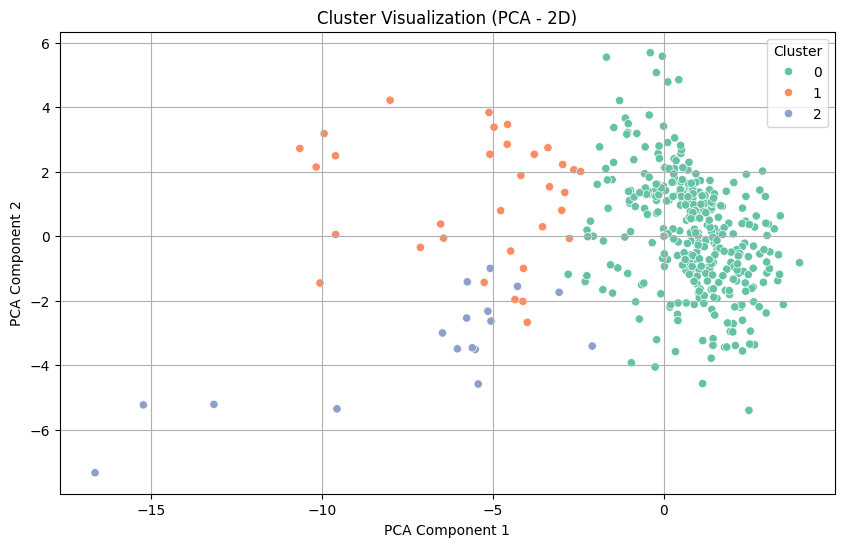

In [101]:
from sklearn.decomposition import PCA

# perform PCA on the scaled data
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# visualize PCA-reduced clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=labels, palette='Set2')
plt.title("Cluster Visualization (PCA - 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

### Exploring the Clusters

We find the centroids of the clusters respective to the features.

In [102]:
print("Cluster Centroids (in original feature scale)")
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=features)
print(centroids_df)

Cluster Centroids (in original feature scale)
   Educational Attainment: Associates Degree: Town %  \
0                                           0.104501   
1                                           0.105767   
2                                           0.070333   

   Educational Attainment: Bachelors Degree: Town %  \
0                                          0.232587   
1                                          0.156328   
2                                          0.228856   

   Educational Attainment: High School Graduate: Town %  \
0                                           0.259552      
1                                           0.294261      
2                                           0.255906      

   Race/Ethnicity: White: Town %  Race/Ethnicity: Black: Town %  \
0                       0.854228                       0.036900   
1                       0.546278                       0.134461   
2                       0.515469                       0.202053   

  

We also calculate the mean of some key features such as median sale price, to see the relationship between the clusters and those features.

In [105]:
# cluster labels are in the main DataFrame
raw_data["Cluster"] = data["Cluster"]

# non-clustering features to compare
other_features = [
    "median_sale_price",
    "avg_sale_price",
    "Per_capita_income_ACS",
    "Net_current_education_expenditures_per_pupil_CSDE"
]

# average per cluster
cluster_means = raw_data.groupby("Cluster")[other_features].mean()
print("\nAverage values of selected features per cluster:")
print(cluster_means)

# medians per cluster
cluster_medians = raw_data.groupby("Cluster")[other_features].median()
print("\nMedian values of selected features per cluster:")
print(cluster_medians)


Average values of selected features per cluster:
         median_sale_price  avg_sale_price  Per_capita_income_ACS  \
Cluster                                                             
0            355861.339895   403578.759204           52792.004702   
1            271096.969697   288767.504978           36295.380952   
2            226323.529412   320243.779387           36371.687500   

         Net_current_education_expenditures_per_pupil_CSDE  
Cluster                                                     
0                                             20234.522307  
1                                             18670.555725  
2                                             17276.066186  

Median values of selected features per cluster:
         median_sale_price  avg_sale_price  Per_capita_income_ACS  \
Cluster                                                             
0                 295000.0   317592.213745                49239.5   
1                 238500.0   254522.161290 

By comparing each cluster across other socioeconomic indicators (ex. income, sale price, education spending), it reveals that Cluster 0 tends to have higher sale prices and income.

### Final Summary of Model
Model: KMeans Clustering (k=3)

Features used:
- Education levels (Associates, Bachelors, High School)
- Race/Ethnicity proportions
- Poverty and unemployment rates
- Crime rates (violent and property)

Evaluation: With a Silhouette Score: of 0.65, the model is able to cluster effectively. The visualization also showed distinctive features between clusters.

Interpretation:
- Cluster 0 may represent lower crime, lower diversity, and higher education towns
- Cluster 1 may show towns with higher poverty/unemployment or crime rates
- Cluster 2 may be moderate across many indicators

Cluster 0 stood out with higher sale prices and income, suggesting a relationship between the clustered features and wealth.